# CI data analysis: availability sequences based on a common carbon budget

In [1]:
# Import libraries:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utils import *
import math

from scipy import optimize
from scipy.optimize import milp

from gekko import GEKKO
from scipy.optimize import linprog
import cvxpy as cp
import copy

import numpy as np

import os
# os.environ['MOSEKLM_LICENCE_FILE'] = "../../mosek"

## Introduction

**Set values for countries and dates:**

In [2]:
# Number of FL training rounds:
n_rounds = 100

# Common carbon budget
global_carbon_budget = 7 # kgCO2e

# Uniform carbon budget
carbon_budget = 1 # kgCO2eq

# list of countries/clients:
countries = ['Ireland', 'Germany', 'Great Britain', 'France', 'Sweden', 'Finland', 'Belgium']
list_colors = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'yellow']

**Definition of variables and useful functions:**

In [3]:
main_folder = 'figures/av-mat-2'

key_words = []
folders = []

n_clients = len(countries)

# Start and end dates:
start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=n_rounds-1)

# data preparation:
_dfs = load_data()
datetime_values = get_datetime_values(_dfs, countries[0], start_date, end_date)

# initialize the similarity matrix:
time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [dt.strftime("%d %h, %H:%M") for dt in time_values]
formatted_array = [i for i in range(n_rounds)]

# functions:
def save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix):
    dict_cols = dict(zip(formatted_array, datetime_values)) # get the datetime values
    availability_matrix_to_save = availability_matrix.rename(columns=dict_cols)
    availability_matrix_to_save.to_csv('availability_matrices/av-mat-2/av-mat_'+key_word+'.csv', columns=datetime_values)

**Raw CI data:**

Let us display the raw data in between the chosen dates.

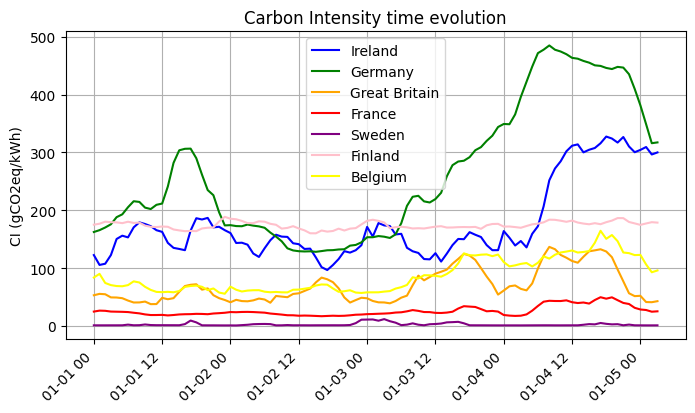

In [4]:
fig = plt.figure(figsize=(8, 4))

for country_idx, country in enumerate(countries):

    df_country = _dfs[country]
    df_to_plot = df_country[df_country['datetime'].between(start_date,end_date)]

    # plot:
    plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])

    # plot legend, axis, etc.:
    # ax.set_xlim([df_to_plot['datetime'].values[0], df_to_plot['datetime'].values[-1]])
    plt.title('Carbon Intensity time evolution')
    plt.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    _ = plt.xticks(rotation=90)  
    plt.grid()
    plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    plt.ylabel('CI (gCO2eq/kWh)')
plt.savefig(os.path.join('figures/av-mat-2/raw_CI_data.png'), bbox_inches='tight')
plt.show()

Lets compute the mean value for each country in between these two dates, and the global mean over all countries.

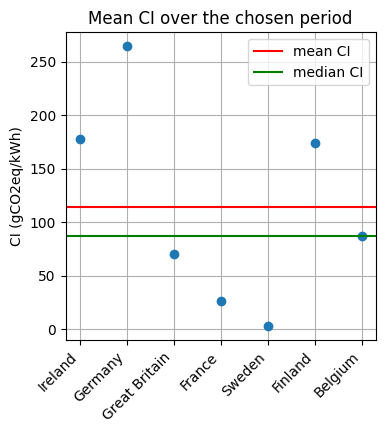

In [5]:
mean_list=[]
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    mean_list.append(CI_values.mean())
dict_countries_CI = dict(zip(countries, mean_list))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plt.plot(countries, mean_list, 'o')
plt.title('Mean CI over the chosen period')
plt.ylabel('CI (gCO2eq/kWh)')
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
plt.grid()

global_mean_CI = np.array(mean_list).mean()
ax.axhline(y=global_mean_CI, color='r', linestyle='-', label='mean CI')

median_CI = np.median(np.array(mean_list))
ax.axhline(y=median_CI, color='g', linestyle='-', label='median CI')

ax.legend()

plt.savefig('figures/av-mat-2/means.png', bbox_inches='tight')

plt.show()

**Carbon Intensity matrix:**

This matrix contains CI values in gCO2eq/kWh.

In [6]:
# initialize the similarity matrix:
# time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [i for i in range(len(time_values))]
CI_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    CI_matrix.loc[country, :] = CI_values

**GHG matrix:** 

We suppose that the power draw for all clients is constant and equal. At the moment we take the constant **300 Watts**.

The formula for carbon footprint is: power (W) * duration (hour) * carbon intensity (gCO2/kWh) * 1000

It contains the values of carbon fooprint of sustaining a certain power during ``round_duration`` hours

In [7]:
power = 300/1000 # in kiloWatts
round_duration = 1 # in hours: this is duration of a FL training round
GHG_matrix = CI_matrix * power * round_duration / 1000
GHG_mat_np = GHG_matrix.to_numpy()

## Creation of availability matrix with the third problem

### Take w=1

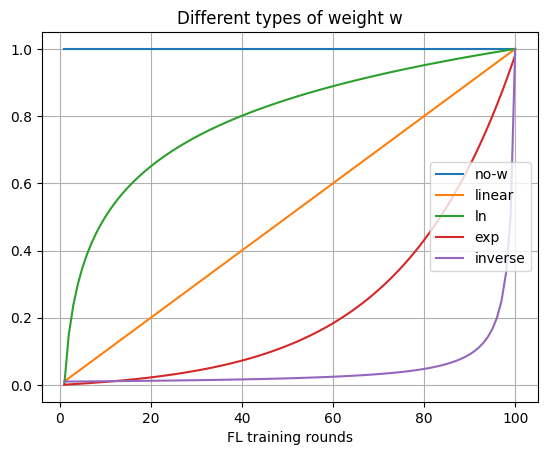

In [8]:
T_max = n_rounds # in hours

rounds_axis = np.array([i for i in range(1, n_rounds+1)])

w_dict = {
    'no-w': np.ones(len(rounds_axis)),
    'linear': 1/T_max*rounds_axis,
    'ln': 1/np.log(T_max)*np.log(rounds_axis),
    'exp': 1/np.exp(T_max/25)*np.exp(rounds_axis/25) - 1/np.exp(T_max/25),
    # 'exp': 1/np.exp(T_max/10)*np.exp(rounds_axis/10) - 1/np.exp(T_max/10),
    'inverse': np.flip(1/rounds_axis)
}

plt.figure()
for key, item in w_dict.items():
    plt.plot(rounds_axis, item, label=key)
plt.legend()
plt.title('Different types of weight w')
plt.xlabel('FL training rounds')
plt.grid()
plt.savefig(main_folder+'/different_w.png', bbox_inches='tight')
plt.show()

### Solve first optimization problem with fairness parameter alpha=0.1

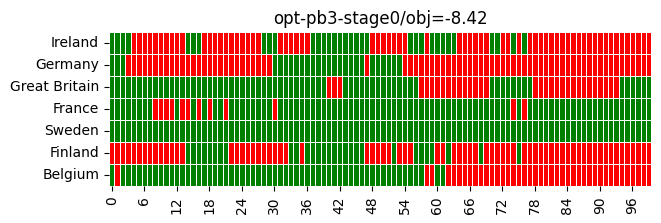

In [9]:
choice_w='no-w'
w = w_dict[choice_w]
alpha_f=0.1

folder = main_folder+'/optimization/pb_3'

key_word = 'opt-pb3-stage0'

GHG_mat = GHG_matrix.to_numpy()
one_m_GHG_w = (np.max(GHG_mat) - GHG_mat)@np.diag(w)

x = cp.Variable(GHG_mat.shape, integer=True)
objective = cp.Minimize(-cp.sum(cp.power(cp.sum(cp.multiply(one_m_GHG_w, x), axis=1), alpha_f)))
constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(GHG_mat, x))<=global_carbon_budget]
prob = cp.Problem(objective, constraints)

result = prob.solve(solver=cp.MOSEK, verbose=False)
availability_matrix = np.array(x.value, dtype=np.int8)

# plot:
plot_availability_heatmap("", pd.DataFrame(availability_matrix, index = countries, columns = formatted_array), key_word, folder=folder, objective=result)
save_availability_matrix(datetime_values, formatted_array, key_word, pd.DataFrame(availability_matrix, index = countries, columns = formatted_array))

### Find the end of the training

In [10]:
def find_largest_false_index(availability_matrix):
    lst = availability_matrix.sum(axis=0) == 0
    largest_index = -1
    for i in range(len(lst)):
        if lst[i] == False:
            largest_index = i
    return largest_index

idx_end_train = find_largest_false_index(availability_matrix)

### Set the last 10 percent to available

idx:  10
[0.38524800000000003 0.3838979999999999 0.373302 0.36177599999999993
 0.344721 0.32854799999999995 0.319866 0.303882 0.28576799999999997
 0.28871399999999997]
remaining budget:  3.6242770000000006


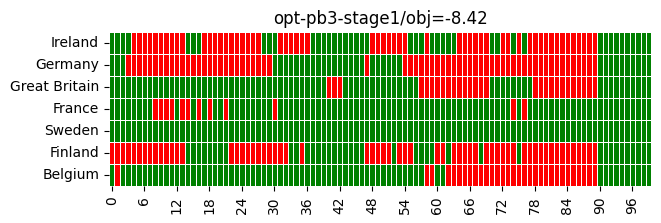

Countries lambda_2:  [0.63, 0.87, 0.85, 0.24, 1.0, 0.64, 0.86]
Mean lambda_2:  0.73


In [13]:
carbon_budget = 7

folder = main_folder+'/optimization/pb_3'

key_word = 'opt-pb3-stage1'

percentage_fine_tuning = 0.1
idx = int(percentage_fine_tuning*availability_matrix.shape[1])
print('idx: ', idx)

GHG_values = GHG_matrix.to_numpy()
GHG_countries = sum(GHG_values[:,-idx:])
print(GHG_countries)

remaining_budget = carbon_budget - sum(GHG_countries)
print('remaining budget: ', remaining_budget)

availability_matrix[:, -idx:] = 1

plot_availability_heatmap("", pd.DataFrame(availability_matrix, index = countries, columns = formatted_array), key_word, folder=folder, objective=result)

lam2_list, corr = av_mat_corr(pd.DataFrame(availability_matrix, index = countries, columns = formatted_array))
print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
print('Mean lambda_2: ',np.round(corr, 2))

### Remove green slots with the highest carbon footprint so as not to exceed the carbon budget

We first put a mask on slots that we should not change in this step.

In [34]:
mask = availability_matrix == 0
mask[:, -idx:] = True

sum(sum(mask))

323

Due to the previous step, the schedule is emitting extra-carbon.

In [35]:
carbon_to_remove = sum(sum(GHG_matrix.to_numpy()*availability_matrix))-carbon_budget
carbon_to_remove

3.0210409999999968

/Users/charlotterodriguez/Desktop/Code/GitHub/venv_greenFL/lib/python3.9/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


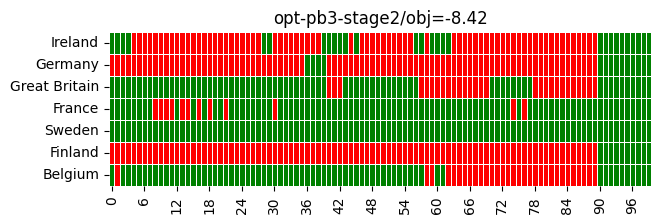

Carbon footprint of this schedule:  6.984824999999998


In [36]:
key_word = 'opt-pb3-stage2'

GHG_mat_np = GHG_matrix.to_numpy()

# mask elements that unavailable, and mask last 10%
# masked elements are set with the value 999999
GHG_mat_masked = np.ma.array(data=GHG_mat_np, mask=mask, fill_value=999999)

# flatten the masked array, but keep the mask
flattened = GHG_mat_masked.flatten()
availability_flattened = availability_matrix.flatten()

# idx_map = np.array([i for i in range(len(flattened))]).reshape(GHG_mat_np.shape)
# print(idx_map)

# sort in increasing order the opposite of the flattened array, masked values are at the beginning
# the original flattened array is sorted in decreasing order, masked values at the end
idx_sort_flattened = (-flattened).argsort()

# apply the sorting to the flattened array
sorted_flattened = np.ma.array([flattened[idx] for idx in idx_sort_flattened])

# compute the cumulative sum
sorted_flattened_cumsum = sorted_flattened.cumsum()

# we are then able to see up to which index we should remove availability
threshold_idx = np.where(sorted_flattened_cumsum > carbon_to_remove)[0][0]

# these are the indexes of slots that will be made non-available
selected_idx = idx_sort_flattened[:threshold_idx+1]

# modification of the availability matrix
availability_flattened[selected_idx] = 0
final_availability_matrix = availability_flattened.reshape(GHG_mat_np.shape)

plot_availability_heatmap("", pd.DataFrame(final_availability_matrix, index = countries, columns = formatted_array), key_word, folder=folder, objective=result)
print('Carbon footprint of this schedule: ',sum(sum(GHG_matrix.to_numpy()*final_availability_matrix)))


save_availability_matrix(datetime_values, formatted_array, key_word, pd.DataFrame(final_availability_matrix, index = countries, columns = formatted_array))

## Appendix

In [37]:
# import numpy as np
# import numpy.ma as ma

# # Create a masked 2-D array
# data = np.array([[1, 2, 3], [4, 5, 6]])
# mask = np.array([[0, 1, 0], [1, 0, 0]])
# masked_array = ma.masked_array(data, mask)

# # Flatten the masked array
# # flattened = masked_array.compressed()  # Ignores masked elements
# flattened = masked_array.flatten() 

# print("Flattened array:", flattened)

# # Reshape the flattened array back to its original shape
# reshaped = ma.masked_array(flattened, mask=None).reshape(masked_array.shape)

# print("Reshaped array:\n", reshaped)